# HW250527-Image_Classification_Problems

## Exercise 1
* Use LeNet, AlexNet to solve the image classification problem.
* the dataset is KMNIST provided by torchvision.datasets
* You can make proper modifications on LeNet and AlexNet.
* Discuss your modifications and recognition results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

### use_deterministic_algorithms
``` Python
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
```
用來支援 
``` Python
torch.use_deterministic_algorithms(True)
```

In [2]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

torch.use_deterministic_algorithms(True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### LeNet
* RGB通道改成灰階，以適用KMNIST
* to(device)
``` Python
lenet = LeNet().to(device)
```
model 搬到 device 裡面計算，優先使用 GPU CUDA 而非 CPU

In [3]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(1, 6, 5)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5)
        # fully connected layers of size 120, 84 and 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Flatten spatial and depth dimensions into a single vector
        x = x.view(-1, self.flattened_features(x))
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats


lenet = LeNet().to(device)
print(lenet)

LeNet(
  (cn1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### def train(net, trainloader, optim, epoch)
1. 從 trainloader 取資料
2. Activation -> backpropagation算梯度 -> optim更新
3. 每 1000 次 印出 Loss
* to(device)
``` Python
ip = ip.to(device)
ground_truth = ground_truth.to(device)
```

In [4]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data
        ip           = ip.to(device)
        ground_truth = ground_truth.to(device)

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass + backward pass + optimization step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # update loss
        loss_total += loss.item()
        
        # print loss statistics
        if (i+1) % 1000 == 0:    # print at the interval of 1000 mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

### def test(net, testloader):
* to(device)
``` Python
im = im.to(device)
ground_truth = ground_truth.to(device)
```

In [5]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            
            im           = im.to(device)
            ground_truth = ground_truth.to(device)
            
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

### Dataset
* KMNIST  
https://docs.pytorch.org/vision/main/generated/torchvision.datasets.KMNIST.html  
https://github.com/rois-codh/kmnist
* Resize  
將KMNIST 28\*28的影像resize成 32\*32

In [6]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
# train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                       transforms.RandomCrop(32, 4),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_transform = transforms.Compose([transforms.Resize(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)


# test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)


# ordering is important
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo')

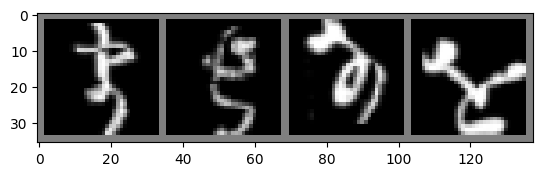

    ma  ||  ki  ||  na  ||  wo


In [7]:
# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

In [8]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

# training loop over the dataset multiple times
for epoch in range(50):  
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 7.605
[Epoch number : 1, Mini-batches:  2000] loss: 5.234
[Epoch number : 1, Mini-batches:  3000] loss: 4.260
[Epoch number : 1, Mini-batches:  4000] loss: 3.530
[Epoch number : 1, Mini-batches:  5000] loss: 3.090
[Epoch number : 1, Mini-batches:  6000] loss: 2.731
[Epoch number : 1, Mini-batches:  7000] loss: 2.452

LeNet accuracy on 10000 images from test dataset: 76 %

[Epoch number : 2, Mini-batches:  1000] loss: 2.308
[Epoch number : 2, Mini-batches:  2000] loss: 2.105
[Epoch number : 2, Mini-batches:  3000] loss: 2.162
[Epoch number : 2, Mini-batches:  4000] loss: 2.012
[Epoch number : 2, Mini-batches:  5000] loss: 1.949
[Epoch number : 2, Mini-batches:  6000] loss: 1.912
[Epoch number : 2, Mini-batches:  7000] loss: 1.836

LeNet accuracy on 10000 images from test dataset: 79 %

[Epoch number : 3, Mini-batches:  1000] loss: 1.840
[Epoch number : 3, Mini-batches:  2000] loss: 1.685
[Epoch number : 3, Mini-batches:  3000] loss: 1.760
[E

In [9]:
model_path = './kmnist_model.pth'
torch.save(lenet.state_dict(), model_path)

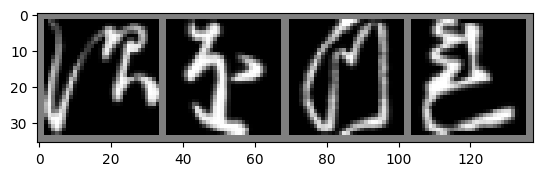

Label:          su    wo   tsu    re
Prediction:     su    wo   tsu    re


In [10]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# model inference
op = lenet_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [11]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 91 %


In [12]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class     o : 92 %
Model accuracy for class    ki : 88 %
Model accuracy for class    su : 88 %
Model accuracy for class   tsu : 95 %
Model accuracy for class    na : 88 %
Model accuracy for class    ha : 85 %
Model accuracy for class    ma : 95 %
Model accuracy for class    ya : 93 %
Model accuracy for class    re : 95 %
Model accuracy for class    wo : 94 %
